# Held-out log-likelihood

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## T-dSB-DP versus N-dSB-DP across K

In [ ]:
def varyK_NvsT(Klist, T, D, inroot, heldoutroot, expset, ax):
    """
    Inputs:
        Klist: list of approximation levels
        T: scalar, per-document cap on number of topics
        D: scalar, mini-batch size 
        expset: list of experimental seeds
        ax: axis to plot
    Outputs:
        plots LL of T-dSB-DP and N-dSB-DP versus number of minibatches
    Remarks: 
        all experiments are expected to run until completion i.e. 
        the same number of iterations.
    """
    nhdp = {}
    nhdp['avg'] = []
    nhdp['err'] = []
    thdp = {}
    thdp['avg'] = []
    thdp['err'] = []
    for i in range(len(Klist)):
        K = Klist[i]
        
        # average held-out log-likelihood at convergence of N-dSB-DP
        nhdpdir = "results/nhdpK" + str(K) + "_T" + str(T) + "_" + "D" + str(D) + "_" + inroot + "_" + heldoutroot
        finalnhdpLL = []
        ## load experiments
        for seed in expset:
            nhdppath = nhdpdir + "/LL_" + str(seed) + ".csv"
            result = np.loadtxt(nhdppath)
            # extract only LL at convergence
            finalnhdpLL.append(result[-1,2])
        finalnhdpLL = np.array(finalnhdpLL) # shape (len(expset),)
        nhdp['avg'].append(np.mean(finalnhdpLL)) # scalar
        nhdp['err'].append(np.std(finalnhdpLL)) # scalar
    
        # average held-out log-likelihood at convergence of T-dSB-DP
        thdpdir = "results/thdpK" + str(K) + "_T" + str(T) + "_" + "D" + str(D) + "_" + inroot + "_" + heldoutroot
        finalthdpLL = []
        ## load experiments
        for seed in expset:
            thdppath = thdpdir + "/LL_" + str(seed) + ".csv"
            result = np.loadtxt(thdppath)
            # extract only LL at convergence 
            finalthdpLL.append(result[-1,2])
        finalthdpLL = np.array(finalthdpLL) # shape (len(expset),)
        thdp['avg'].append(np.mean(finalthdpLL)) # scalar
        thdp['err'].append(np.std(finalthdpLL)) # scalar
        
    ax.errorbar(Klist, nhdp['avg'], yerr=nhdp['err'],label='N-dSB-DP')
    ax.errorbar(Klist, thdp['avg'], yerr=thdp['err'],label='T-dSB-DP')
    
    ax.set_title('D = %d, T = %d' %(D,T))
    ax.set_xlabel('K')
    ax.set_ylabel('Held-out log-likelihood at convergence')
    ax.legend()
    
    return 

In [ ]:
Klist = [10, 30, 50, 70, 90]
Dlist = [20, 50, 100]
T = 10


plt.figure()
varyK_NvsT(Klist, T, Dlist[0], "wiki10k","wiki1k", range(0,5), plt.gca())

"""
fig, axes = plt.subplots(1,3,figsize=(12,4))

for i in range(3):
    varyK_NvsT(Klist, T, Dlist[i], "wiki10k","wiki1k", range(0,5), axes[i])
"""

plt.tight_layout()
plt.show()

# Inferred topics

In [ ]:
import numpy as np
import pandas as pd

In [ ]:
from utils import GEM_expectation
import matplotlib.pyplot as plt

def printtopics(vocabfile, file, method, dirthresh, probthresh, displaycount):
    """
    Inputs:
        vocabfile:
        file:
        method:
        dirthresh:
        probthresh:
        displaycount:
    Outputs:
    """
    vocab = open(vocabfile).readlines()
    testlambda = np.loadtxt(file["lambda"])
    # compute expectation of topic's underlying probability
    testa = np.loadtxt(file["a"])
    if (method == "thdp"):
        testb = np.loadtxt(file["b"]) 
        probs = GEM_expectation(testa[np.newaxis,:],testb[np.newaxis,:]).flatten()
    elif (method == "nhdp"):
        probs = testa/np.sum(testa)
        
    # sort topics first by probs
    idx = [i for i in reversed(np.argsort(probs))]
    probs = probs[idx]
    testlambda = testlambda[idx, :]
        
    # how many topics explain most of the data?
    cumsum = np.cumsum(probs)
    for i in range(0, len(testlambda)):
        if (cumsum[i]>probthresh):
            lastidx = i
            break
    
    # plot the expectations
    plt.figure()
    plt.plot(probs, marker='o', markersize=4, label='Expected proportions',color='b')
    plt.axvline(x=lastidx,label='Last explanatory topic',color='r', linestyle='--')
    plt.title("Expected underlying proportions. \n Explanatory threshold %.2f" %probthresh)
    plt.xlabel("Topic index")
    plt.ylabel("Underlying proportions")
    plt.legend()
    plt.show()
    
    sigtopics = 0
    df = pd.DataFrame() 
    for k in range(0, len(testlambda)):
        lambdak = list(testlambda[k, :])
        lambdak = [round(i,1) for i in lambdak]
        temp = list(zip(lambdak, list(range(0, len(lambdak)))))
        temp = sorted(temp, key = lambda x: x[0], reverse=True)
        dirichlets = np.array(temp)[:,0]
        widices = np.array(temp,dtype=int)[:,1]
        # plot topics with parameters exceeding the threshold
        if (dirichlets[0] >= dirthresh):
            meanparam = np.mean(dirichlets[:displaycount])
            colname = "%d: prob %.2f, mean %.2f" % (k, probs[k], meanparam)
            coldata = [(str.strip(vocab[widices[i]]), dirichlets[i]) for i in range(0, displaycount)]
            df[colname] = coldata
    print("Discovered %d significant topics at dirichlet threshold %.2f" %(len(df.columns),threshold))
    return df

### T_HDP output with no topic ordering 

In [ ]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/thdpK100_D50_wiki10k_wiki1k/lambda-400.dat"
file["a"] ="results/thdpK100_D50_wiki10k_wiki1k/a-400.dat"
file["b"] ="results/thdpK100_D50_wiki10k_wiki1k/b-400.dat"
normalized = False
method = "thdp"
threshold = 50
displaycount = 10
df = printtopics(vocabfile, file, method, normalized, threshold, displaycount)
df

### T_HDP with topic ordering but slightly incorrect E-step due to expect_log_sticks

In [ ]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/thdpK100_D20_wiki10k_wiki1k/lambda-400.dat"
file["a"] ="results/thdpK100_D20_wiki10k_wiki1k/a-400.dat"
file["b"] ="results/thdpK100_D20_wiki10k_wiki1k/b-400.dat"
normalized = False
method = "thdp"
threshold = 200
displaycount = 10
df = printtopics(vocabfile, file, method, normalized, threshold, displaycount)
df

### T_HDP with topic ordering, slightly incorrect E-step due to expect_log_sticks, ran for almost 1000 mini-batches

In [ ]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/thdpK100_D20_wiki10k_wiki1k/lambda-800.dat"
file["a"] ="results/thdpK100_D20_wiki10k_wiki1k/a-800.dat"
file["b"] ="results/thdpK100_D20_wiki10k_wiki1k/b-800.dat"
normalized = False
method = "thdp"
threshold = 200
displaycount = 10
df = printtopics(vocabfile, file, method, normalized, threshold, displaycount)
df

### T_HDP with topic ordering, corrected E-step, ran for a small number of mini-batches

In [ ]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/thdpK100_T20_D50_wiki10k_wiki1k/lambda-100.dat"
file["a"] ="results/thdpK100_T20_D50_wiki10k_wiki1k/a-100.dat"
file["b"] ="results/thdpK100_T20_D50_wiki10k_wiki1k/b-100.dat"
method = "thdp"
dirthresh = 200
probthresh = 0.95
displaycount = 10
df = printtopics(vocabfile, file, method, dirthresh, probthresh, displaycount)
df

In [ ]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/thdpK100_T20_D50_wiki10k_wiki1k/lambda-500.dat"
file["a"] ="results/thdpK100_T20_D50_wiki10k_wiki1k/a-500.dat"
file["b"] ="results/thdpK100_T20_D50_wiki10k_wiki1k/b-500.dat"
method = "thdp"
dirthresh = 400
probthresh = 0.95
displaycount = 10
df = printtopics(vocabfile, file, method, dirthresh, probthresh, displaycount)
df

### N_HDP, corrected E-step, small number of mini-batches 

In [ ]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/nhdpK100_T20_D50_wiki10k_wiki1k/lambda-100.dat"
file["a"] ="results/nhdpK100_T20_D50_wiki10k_wiki1k/a-100.dat"
file["b"] ="results/nhdpK100_T20_D50_wiki10k_wiki1k/b-100.dat"
method = "nhdp"
probthresh = 0.95
dirthresh = 200
displaycount = 10
df = printtopics(vocabfile, file, method, dirthresh, probthresh, displaycount)
df

In [ ]:
vocabfile = "dictnostops.txt"
file = {}
file["lambda"] ="results/nhdpK100_T20_D50_wiki10k_wiki1k/lambda-500.dat"
file["a"] ="results/nhdpK100_T20_D50_wiki10k_wiki1k/a-500.dat"
file["b"] ="results/nhdpK100_T20_D50_wiki10k_wiki1k/b-500.dat"
method = "nhdp"
probthresh = 0.95
dirthresh = 200
displaycount = 10
df = printtopics(vocabfile, file, method, dirthresh, probthresh, displaycount)
df

# Warm-start

In [3]:
from wikipedia import debug
from wikipedia import makesaves
from wikipedia import maketopicfile
from evaltopics import evaltopics
from utils import TrainSpecs
import matplotlib.pyplot as plt

## Evaluate N(T)-dSB-DP predictive distribution using LDA topics

### LDA topics after 2000 documents

In [ ]:
method = "thdp" 
topicinfo = ["LDA", "results/ldaK100_D50_wiki10k_wiki1k/","100"]
debug(method, topicinfo)

In [ ]:
method = "nhdp" 
topicinfo = ["LDA", "results/ldaK100_D50_wiki10k_wiki1k/","100"]
debug(method, topicinfo)

### LDA topics after different number of mini-batches

  0%|          | 0/9 [00:00<?, ?it/s]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-0.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.61


 11%|█         | 1/9 [00:41<05:30, 41.32s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-100.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.61


 22%|██▏       | 2/9 [01:34<05:14, 44.92s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-200.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.61


 33%|███▎      | 3/9 [02:23<04:36, 46.05s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-300.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.61


 44%|████▍     | 4/9 [03:15<03:59, 47.85s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-400.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.60


 56%|█████▌    | 5/9 [04:04<03:12, 48.13s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-500.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.59


 67%|██████▋   | 6/9 [04:49<02:21, 47.16s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-600.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.59


 78%|███████▊  | 7/9 [05:30<01:30, 45.33s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-700.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.59


 89%|████████▉ | 8/9 [06:14<00:45, 45.09s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-800.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.60


  0%|          | 0/9 [00:00<?, ?it/s]

[-8.690190077591753, -7.38500418304376, -7.3282378720046895, -7.304029460519426, -7.314953464615891, -7.326021236751706, -7.338694375541374, -7.354139757213254, -7.370244763114952]
Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-0.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.62


 11%|█         | 1/9 [00:43<05:44, 43.07s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-100.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.61


 22%|██▏       | 2/9 [01:33<05:17, 45.37s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-200.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.61


 33%|███▎      | 3/9 [02:23<04:40, 46.73s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-300.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.61


 44%|████▍     | 4/9 [03:09<03:52, 46.50s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-400.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.61


 56%|█████▌    | 5/9 [03:59<03:10, 47.53s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-500.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.62


 67%|██████▋   | 6/9 [04:51<02:26, 48.71s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-600.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.63


 78%|███████▊  | 7/9 [05:40<01:38, 49.03s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-700.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.61


 89%|████████▉ | 8/9 [06:27<00:48, 48.36s/it]

Successfully loaded topics from results/ldaK100_D50_wiki10k_wiki1k/lambda-800.dat
Time to initialize 100-topic model, each document using 10 topics, is 0.62


100%|██████████| 9/9 [07:11<00:00, 47.14s/it]

[-8.708407872939713, -7.395819501527247, -7.327511209302736, -7.304559481826493, -7.31265010247221, -7.332173165458577, -7.3547113929704375, -7.3706200051860336, -7.390333959445528]


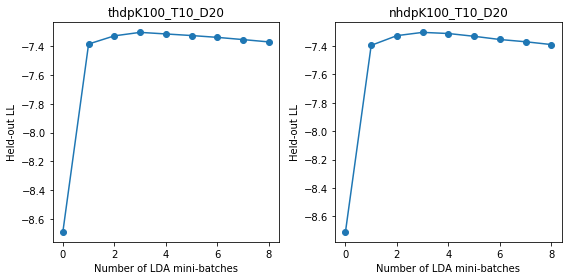

In [3]:
args1 = TrainSpecs(train=False, test=True, method='thdp', K=[100], T=10, LLiter=100, progressiter=10, topiciter=100,
                      inroot='wiki10k', heldoutroot='wiki1k', tau=1024, kappa = 0.7, seed=0, 
                      maxiter=1000, batchsize=20)
args2 = TrainSpecs(train=False, test=True, method='nhdp', K=[100], T=10, LLiter=100, progressiter=10, topiciter=100,
                      inroot='wiki10k', heldoutroot='wiki1k', tau=1024, kappa = 0.7, seed=0, 
                      maxiter=1000, batchsize=20)

iterations = range(0,900,100)
topicroot = ["LDA","results/ldaK100_D50_wiki10k_wiki1k/"]

fig, axes = plt.subplots(1,2,figsize=(8,4))

evaltopics(args1, topicroot, iterations, axes[0])
evaltopics(args2, topicroot, iterations, axes[1])

plt.tight_layout()
plt.show()

## Warm-start training of N(T)-dSB-DP using LDA topics

### T-dSB-DP versus number of minibatches

In [26]:
def warm(K, T, D, method, inroot, heldoutroot, tau, kappa, topicinfo, expset, ax):
    """
    Inputs:
        K: corpus-level truncation
        T: document-level truncation
        D: mini-batch size 
        tau:
        kappa:
        inroot: "wiki10k" for instance
        heldoutroot: "wiki1k" for instance
        expset: list of experimental seeds
    Outputs:
        plots LL of thdp versus number of mini-batches
    """
    
    # find the right directory
    topicfile = maketopicfile(topicinfo)
    LL = []
    ## load experiments
    for seed in expset:
        _, LLsavename = makesaves(K, T, D, inroot, heldoutroot, seed, topicfile, method, tau, kappa)
        result = np.loadtxt(LLsavename)
        batchcounts = result[:,0]
        LL.append(result[:,2])
        
    LL = np.array(LL) # shape len(expset) x maxbatchcount
    LLavg = np.mean(LL, axis=0) # shape (maxbatchcount,)
    LLerr = np.std(LL, axis=0) # shape (maxbatchcount,)
    
    ax.errorbar(batchcounts, LLavg, yerr=LLerr,label=method)
    ax.set_title('K = %d, T = %d, D = %d' %(K,T,D))
    ax.set_xlabel('Number of mini-batches')
    ax.set_ylabel('Held-out log-likelihood')
    ax.legend()
    
    return


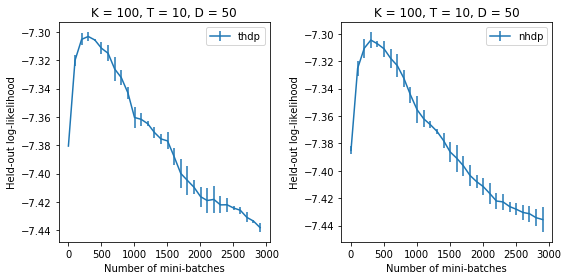

In [27]:
topicinfo = ["LDA","results/ldaK100_D50_wiki10k_wiki1k/","100"]
fig, axes = plt.subplots(1,2,figsize=(8,4))
warm(100, 10, 50, "thdp","wiki10k", "wiki1k", 1024., 0.7, topicinfo, range(0,2),axes[0])
warm(100, 10, 50, "nhdp","wiki10k", "wiki1k", 1024., 0.7, topicinfo, range(0,5),axes[1])
plt.tight_layout()
plt.show()